In [2]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [3]:
def generate_prime(nbits):
    '''
    :param nbits:   number of bits of the prime number
    :return:        prime number with nbits bits
    '''
    if nbits < 2:
        return 2
    while True:
        b = random.getrandbits(nbits-1)
        b = bin(b)[2:]
        while len(b) < nbits-1:
            b = "0" + b
        b = int("0b1" + b, 2)
        p = sympy.nextprime(b)
        if len(bin(p)[2:]) == nbits:
            break
    return p

def generate_a(p):
    '''
    :param p:   prime number
    :return:    a number from 1 to p-1
    '''
    bin_p = bin(p)[2:]
    max_len = len(bin_p)
    below = 0
    while below == 0:
        a = random.getrandbits(max_len)
        if a <= p-1:
            below = 1
    return a, max_len

def generate_data(max_len, a, p, N):
    '''
    :param max_len: max length of the binary representation of the prime number p
    :param a:       number from 1 to p-1
    :param p:       prime number
    :param N:       number of samples
    :return:        X - array of binary representations of the numbers a*x, with x from 0 to p-1
                    Y - array of last 3 bits of the numbers x
    '''
    X, Y = [], np.zeros((3, N))
    for i in range(N):
        x = random.getrandbits(max_len-1)
        result = bin((a*x) % p)[2:]
        result = "0" * (max_len - len(result)) + result
        X.append([int(el) for el in result])
        nx = bin(x)[2:]
        while len(nx) < 3:
          nx = "0" + nx
        Y[0][i] = (int(nx[-1]))
        Y[1][i] = (int(nx[-2]))
        Y[2][i] = (int(nx[-3]))

    X = np.array(X, dtype='float32')
    for i in range(len(Y)):
      Y[i] = np.array(Y[i], dtype='int')
    return X, Y

class BaseModel1(nn.Module):
    def __init__(self, max_len):
        super(BaseModel1, self).__init__()
        self.linear1 = nn.Linear(max_len, 1000)
        self.linear2 = nn.Linear(1000, 1000)
        self.linear3 = nn.Linear(1000, 2)

    def forward(self, inputs):
        h1 = torch.sigmoid(self.linear1(inputs))
        h2 = torch.sigmoid(self.linear2(h1))
        logits = self.linear3(h2)
        return logits


In [4]:
k = 5       # number of experiments for each pair (bitsize, bit)
N = 5000    # number of samples for each experiment
nbits_range = [16, 18, 20, 22, 24, 26] # range of bitsizes
epochs = 2000 # number of epochs for each experiment
train_accs = np.zeros((len(nbits_range), k, epochs)) # array of train accuracies
test_accs = np.zeros((len(nbits_range), k, epochs)) # array of test accuracies
batch_size = 100 # batch size for training

data = {"bitsize":[], "bit":[], "prime_#":[], "epoch":[], "train_acc":[], "test_acc":[]} # dataframe for saving results

In [7]:
for nbits in nbits_range:
    print("Checking for nbits = {}".format(nbits))

    for j in range(k):      
        p = generate_prime(nbits)
        print("prime number", j, ":", p)
        a, max_len = generate_a(p)
        X, Y = generate_data(max_len, a, p, N)
        
        for b in range(len(Y)):
            X_train, X_test, y_train, y_test = train_test_split(X, Y[b], test_size=0.3, random_state=42)

            X_train = torch.from_numpy(X_train)
            y_train = torch.from_numpy(y_train)

            X_test = torch.from_numpy(X_test)
            y_test = torch.from_numpy(y_test)

            train_dataset = TensorDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size)

            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)

            model = BaseModel1(max_len)
            model.cuda()
            optimizer = torch.optim.Adam(model.parameters())
            h = -1

            for i in range(epochs):
                train_correct = 0
                total_train_loss = 0
                total_test_loss = 0
                test_correct = 0

                for (x, y) in train_loader:
                    model.zero_grad()
                    optimizer.zero_grad()
                    x = x.cuda()
                    y = y.type(torch.LongTensor)
                    y = y.cuda()
                    logits = model(x)

                    loss = F.cross_entropy(logits, y)
                    loss.backward()
                    optimizer.step()
                    total_train_loss += loss.item()
                    train_correct += (torch.argmax(logits, axis=1) == y).sum().item()

                with torch.no_grad():
                    for (x, y) in test_loader:
                        x = x.cuda()
                        y = y.type(torch.LongTensor)
                        y = y.cuda()

                        logits = model(x)
                        loss = F.cross_entropy(logits, y)
                        total_test_loss += loss.item()
                        test_correct += (torch.argmax(logits, axis=1) == y).sum().item()

                train_acc = train_correct / len(X_train)
                train_loss = total_train_loss / len(X_train)
                test_loss = total_test_loss / len(X_test)
                test_acc = test_correct / len(X_test)

                data["bitsize"].append(nbits)
                data["bit"].append(b+1)
                data["prime_#"].append(j)
                data["epoch"].append(i)
                data["train_acc"].append(train_acc)
                data["test_acc"].append(test_acc)

                if i % 100 == 0:
                    print("Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}". \
                        format(i, train_loss, train_acc, test_loss, test_acc))

Checking for nbits = 16
prime number 0 : 49783
Epoch: 0, Train Loss: 0.0072, Train Acc: 0.5066, Test Loss: 0.0075, Test Acc: 0.5053
Epoch: 100, Train Loss: 0.0069, Train Acc: 0.5063, Test Loss: 0.0070, Test Acc: 0.5227
Epoch: 200, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 300, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 400, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 500, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 600, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 700, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 800, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 900, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.0000
Epoch: 1000, Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0000, Test Acc: 1.00

In [7]:
#use generated data or load from csv

data = pd.DataFrame(data)
#data = pd.read_csv("bits_new.csv", index_col = 0)
data.to_csv("bits_new.csv", index=True)

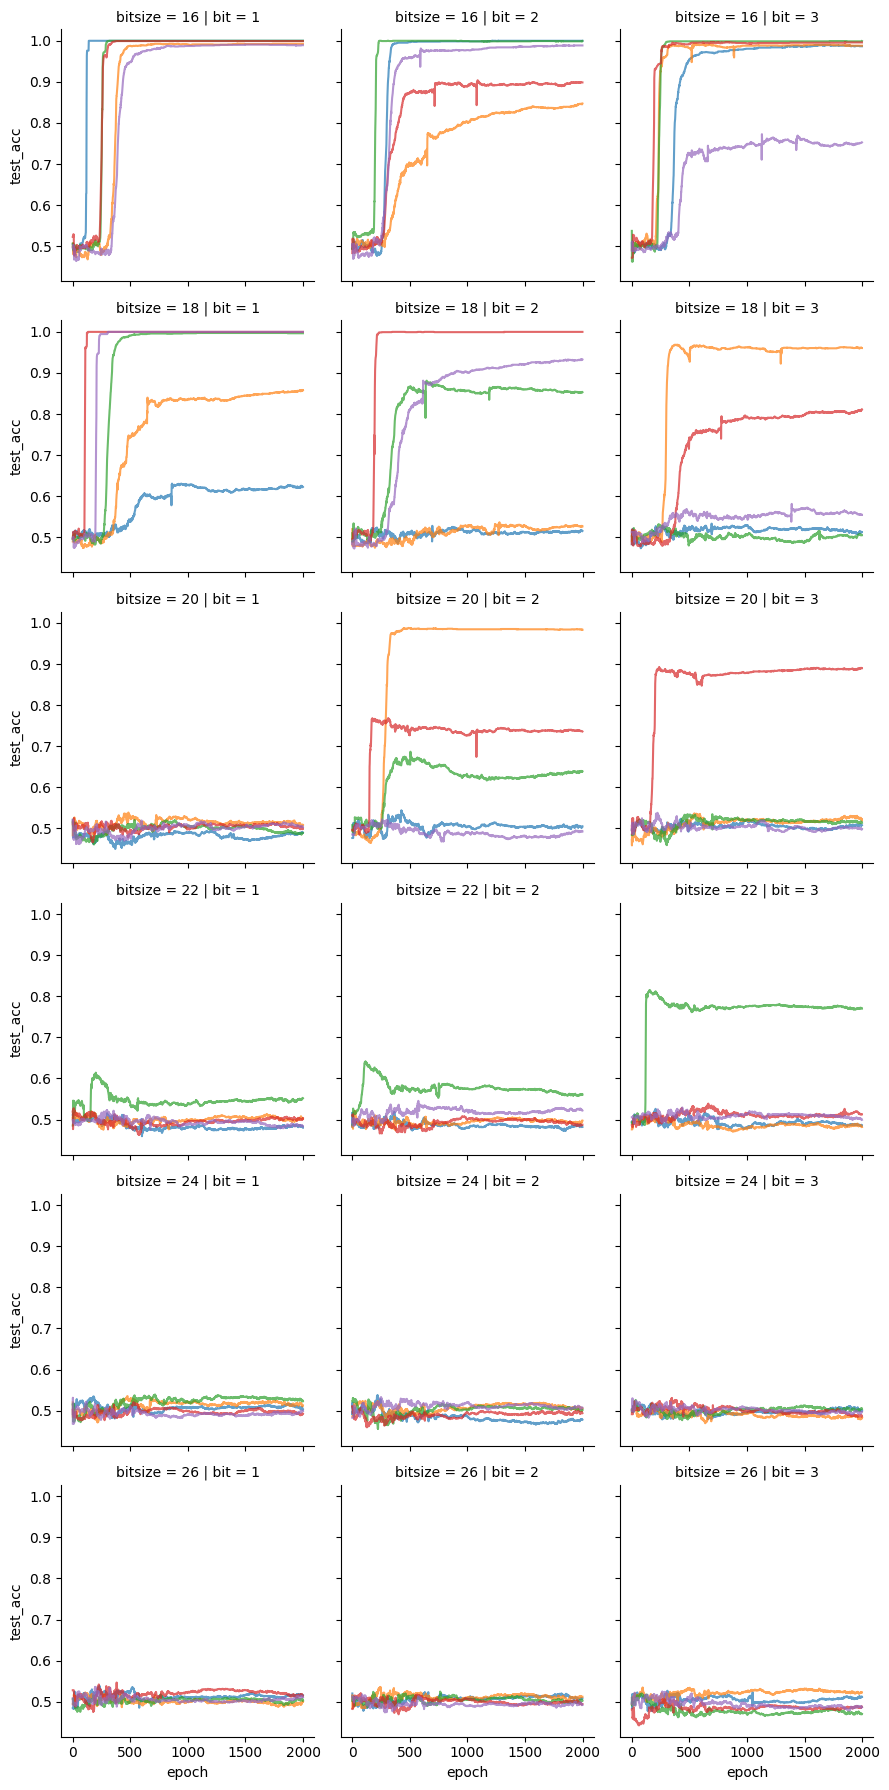

In [9]:
g = sns.FacetGrid(data, col="bit", row="bitsize", hue="prime_#")
g.map(sns.lineplot, "epoch", "test_acc", alpha=.7)
plt.show()

In [10]:
# for each bitsize and bit find prime_# with highest test_acc

maxp = np.zeros((3 ,len(nbits_range)))

data1 = pd.DataFrame({"bitsize":[], "bit":[], "prime_#":[], "epoch":[], "train_acc":[], "test_acc":[]})

for bitsize, i in zip(nbits_range, range(len(nbits_range))):
    for bit in range(1, 4):
        temp1 = data[(data["bitsize"]==bitsize) & (data["bit"]==bit)]
        temp = temp1.groupby("prime_#").max().reset_index()
        maxp[bit-1, i] = temp.loc[temp["test_acc"].idxmax()]["prime_#"]
        print("bitsize:", bitsize, "bit:", bit, "prime_#:", temp.loc[temp["test_acc"].idxmax()]["prime_#"], "test_acc:", temp["test_acc"].max())
        data1 = pd.concat([data1, temp1[temp1["prime_#"] == maxp[bit-1, i]]])

bitsize: 16 bit: 1 prime_#: 0.0 test_acc: 1.0
bitsize: 16 bit: 2 prime_#: 0.0 test_acc: 1.0
bitsize: 16 bit: 3 prime_#: 2.0 test_acc: 0.9993333333333332
bitsize: 18 bit: 1 prime_#: 3.0 test_acc: 1.0
bitsize: 18 bit: 2 prime_#: 3.0 test_acc: 1.0
bitsize: 18 bit: 3 prime_#: 1.0 test_acc: 0.9686666666666668
bitsize: 20 bit: 1 prime_#: 1.0 test_acc: 0.5386666666666666
bitsize: 20 bit: 2 prime_#: 1.0 test_acc: 0.988
bitsize: 20 bit: 3 prime_#: 3.0 test_acc: 0.892
bitsize: 22 bit: 1 prime_#: 2.0 test_acc: 0.614
bitsize: 22 bit: 2 prime_#: 2.0 test_acc: 0.6413333333333333
bitsize: 22 bit: 3 prime_#: 2.0 test_acc: 0.8146666666666667
bitsize: 24 bit: 1 prime_#: 2.0 test_acc: 0.5393333333333333
bitsize: 24 bit: 2 prime_#: 0.0 test_acc: 0.538
bitsize: 24 bit: 3 prime_#: 3.0 test_acc: 0.5306666666666666
bitsize: 26 bit: 1 prime_#: 3.0 test_acc: 0.5466666666666666
bitsize: 26 bit: 2 prime_#: 1.0 test_acc: 0.536
bitsize: 26 bit: 3 prime_#: 1.0 test_acc: 0.5346666666666666


In [ ]:
cv = {"bitsize": int}
data1 = data1.astype(cv)
sns.set_context("paper", font_scale=2)

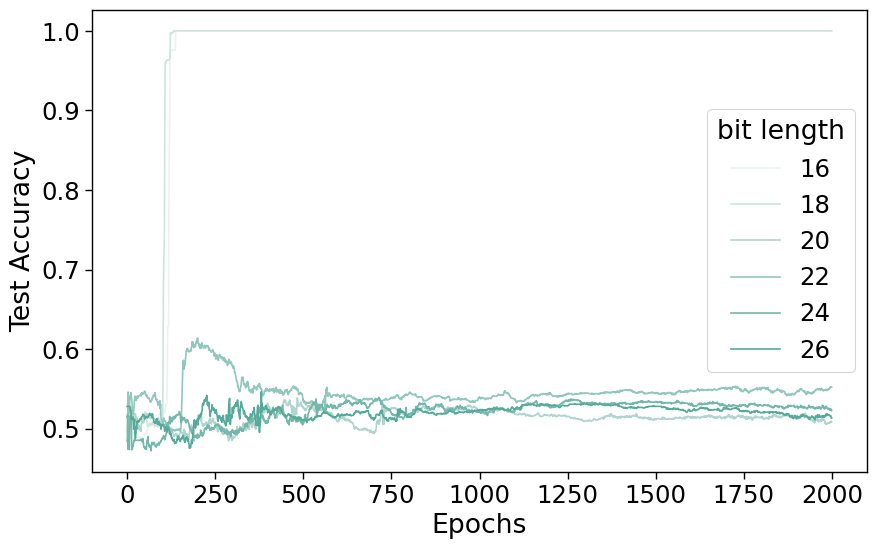

In [30]:
plt.figure(figsize=(10, 6))
g1 = sns.lineplot(x="epoch", y="test_acc", hue="bitsize", data=data1[data1["bit"]==1], palette="light:#5A9")
#g2 = sns.lineplot(x="epoch", y="test_acc", hue="bitsize", data=data1[data1["bit"]==2], palette="ch:s=.25,rot=-.25")
#g3 = sns.lineplot(x="epoch", y="test_acc", hue="bitsize", data=data1[data1["bit"]==3], palette="flare")
#plt.legend(title="bit length", loc="lower right", labels=["16", "18", "20", "22", "24", "26"])
plt.legend(title="bit length", loc = "center right")
#plt.title("Test Accuracy vs Epochs, Third-to-last bit")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.show()